In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import fitsio
from fitsio import FITS, FITSHDR
import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import time

In [2]:
from some_func import cart2spheric, spheric2cart, spheric_coordinates_rotate, hor2pix_s1c, bright_relay_s1c

In [3]:
img_num=467
# img_num=3351

In [4]:
pic_save_name='/home/ashindin/temp/' + "{0:0>3}".format(img_num) + '.png'

In [5]:
fit_filename='/mnt/Work_disk/Owncloud/0000_Two_points/DATA/01_S1C/140824/aug24red15bin2_0' + "{0:0>3}".format(img_num) + '.fit'
dark_filename='/mnt/Work_disk/Owncloud/0000_Two_points/DATA/01_S1C/140824/dark/s1c_aug24_dark_median.fit'
BS6300_catalog_filename='Haritonov_6300BS_catalog.npz'

In [6]:
# Координаты расположения S1C
lat_s1c=56.1501667 # ШИРОТА
lon_s1c=46.1050833 # ДОЛГОТА
h_s1c=183.0
S1C_site=EarthLocation(lat=lat_s1c*u.deg, lon=lon_s1c*u.deg, height=h_s1c*u.m)

# Ориентация S1C - 24 августа
az0_s1c = 5.25221062496641;
alt0_s1c = 1.5541049224175232;
a_s1c = (-0.2348695544502367, 0.0004395865611329251, 0.001172237836255852)
b_s1c = (0.10820004418209775, -0.0011720136387002968, 0.000437125282422439)
c_s1c = ( 146.55099832248433, 279.114199528675, -748.5277665569147)
d_s1c = ( 145.4040578902056, 748.3731317338136, 280.7000564862628)

In [7]:
npzfile=np.load(BS6300_catalog_filename)
CAT_FIELDS=npzfile['CAT_FIELDS']
CAT_6300BS=npzfile['CAT_6300BS']
CAT_SPTYPE=npzfile['CAT_SPTYPE']
print(CAT_FIELDS)

['HARITONOV_ID' 'BS_ID' 'RA (icrs, deg)' 'DEC (icrs, deg)' 'MAG_V'
 '6300 Flux (erg/(sm^2 * s *  sm))']


In [8]:
fitfile=fitsio.FITS(fit_filename)
img=fitfile[0].read()
dark=fitsio.read(dark_filename)
img=img.astype('d')-dark.astype('d')
header=fitfile[0].read_header()
fitfile.close()
date_obs_str=header['COMMENT'][7:31]
if date_obs_str[16]==' ':
    date_obs_str=date_obs_str[0:16] + '0' + date_obs_str[17:24]
if date_obs_str[17]==' ':
    date_obs_str=date_obs_str[0:17] + '0' + date_obs_str[18:24]
date_obs=datetime.datetime.strptime(date_obs_str,"%b %d %H:%M:%S.%f %Y") - datetime.timedelta(seconds=7.5) - datetime.timedelta(hours=4)
print(date_obs)

2014-08-24 19:39:39.504000


In [9]:
BS_coord=SkyCoord(CAT_6300BS[:,2], CAT_6300BS[:,3], frame='icrs', unit='deg');

altaz=BS_coord.transform_to(AltAz(obstime=date_obs, location=S1C_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                       relative_humidity=0.5,obswl=630.0*u.nm))
BS_AzAlt=np.zeros((np.size(CAT_6300BS,0),2))
BS_AzAlt[:,0]=altaz.az.degree
BS_AzAlt[:,1]=altaz.alt.degree

In [10]:
BS_xy=np.zeros((np.size(CAT_6300BS,0),2))
BS_xy[:,0], BS_xy[:,1] = hor2pix_s1c (BS_AzAlt[:,0]*np.pi/180,BS_AzAlt[:,1]*np.pi/180, az0_s1c, alt0_s1c, c_s1c, d_s1c)

In [11]:
# Catalog filtration
filt_mask=np.zeros(np.size(CAT_6300BS,0),dtype=bool)
for i in range(0,np.size(CAT_6300BS,0)):
    if BS_AzAlt[i,1]>=85.0:
        if BS_xy[i,0]>=1 and BS_xy[i,0]<=288:
            if BS_xy[i,1]>=1 and BS_xy[i,1]<=288:
                filt_mask[i]=True
BS_AzAlt_filt=BS_AzAlt[filt_mask,:]
BS_xy_filt=BS_xy[filt_mask,:]
CAT_6300BS_filt=CAT_6300BS[filt_mask,:]
CAT_SPTYPE_filt=CAT_SPTYPE[filt_mask]

In [12]:
np.size(BS_xy_filt,0)

1

In [13]:
CAT_6300BS_filt[:,0]

array([ 466.])

In [14]:
np.median(img)

193.0

In [15]:
int(BS_xy_filt[:,0][0]),int(BS_xy_filt[:,1][0])

(178, 135)

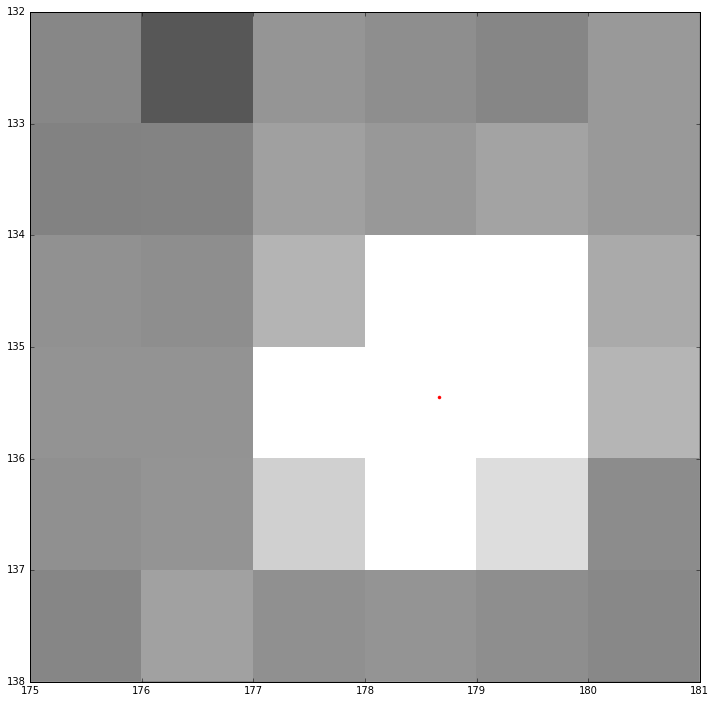

In [16]:
area_rad=3

fig=plt.figure(figsize=(12,12))
ax = plt.subplot(111)
# plt.imshow(img, cmap="gray", vmin=300, vmax=900)
plt.pcolormesh(img, cmap="gray", vmin=np.median(img)-100, vmax=np.median(img)+100)

plt.plot(BS_xy_filt[:,0],BS_xy_filt[:,1],color="r",marker=".", lw=0.,mec="r", mfc="r")

ax.set_xlim([178-area_rad,178+area_rad]);
ax.set_ylim([135+area_rad,135-area_rad]);

# ax.set_xlim([178-10,178+10]);
# ax.set_ylim([135+10,135-10]);


# ax.set_xlim((1,288))
# ax.set_ylim((288,1))
# plt.colorbar
plt.show()

In [17]:
img_red_st_int=np.zeros(np.size(BS_xy_filt,0))
img_red_st_num=np.zeros(np.size(BS_xy_filt,0))
BS_adc_filt=np.zeros(np.size(BS_xy_filt,0))
area_rad=3
for j in range(np.size(BS_xy_filt,0)):    
    st_x=BS_xy_filt[j,0]
    st_y=BS_xy_filt[j,1]
    area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

    sum_temp=0.0
    num=0
    med=np.median(area)
    for i in range(len(area.flat)):
        if area.flat[i]>=1.3*med:
            num+=1
            sum_temp+=area.flat[i]-med
    img_red_st_int[j]=sum_temp
    img_red_st_num[j]=num
    if num>0:
        BS_adc_filt[j]=sum_temp/num

In [18]:
print(BS_adc_filt[:])

[ 754.66666667]


In [19]:
print(img_red_st_num)

[ 6.]


In [27]:
CAT_6300BS_filt[i,5]

0.0046449999999999998

In [28]:
print(area)

[[  199.   161.   210.   204.   198.   213.   205.]
 [  195.   196.   218.   212.   221.   213.   197.]
 [  207.   204.   234.   445.   594.   226.   208.]
 [  208.   208.   310.  2765.  1264.   235.   205.]
 [  206.   209.   256.   398.   266.   203.   205.]
 [  198.   219.   206.   209.   204.   200.   209.]
 [  205.   198.   201.   215.   204.   190.   195.]]


In [20]:
BS_relay=np.zeros(np.size(BS_xy_filt,0))
R_adc_coef=np.zeros(np.size(BS_xy_filt,0))
for i in range(np.size(BS_xy_filt,0)):
     if img_red_st_num[i]>3:
            BS_relay[i]=bright_relay_s1c(CAT_6300BS_filt[i,5],img_red_st_num[i])
            if BS_adc_filt[i]>0 and BS_relay[i]>100:
                R_adc_coef[i]=BS_relay[i]/BS_adc_filt[i]

In [21]:
print(BS_relay)

[ 1950.93558755]


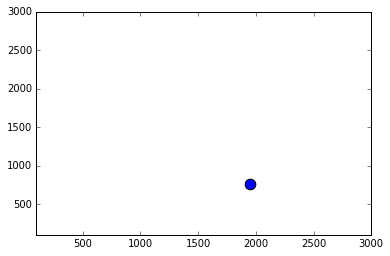

In [24]:
fig,ax = plt.subplots()
plt.scatter(BS_relay,BS_adc_filt,s=np.pi*(img_red_st_num)**2)
ax.set_xlim((100, 3000))
ax.set_ylim((100, 3000))
plt.show()

In [25]:
print(R_adc_coef[R_adc_coef.nonzero()])
R_median=np.median(R_adc_coef[R_adc_coef.nonzero()])
print(R_median)

[ 2.585162]
2.58516199764


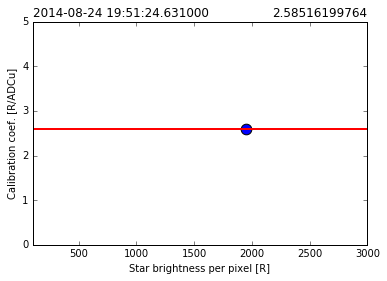

In [26]:
fig,ax = plt.subplots()
plt.plot([0, 5000], [R_median, R_median], c='r', lw=2)
plt.scatter(BS_relay,R_adc_coef,s=np.pi*(img_red_st_num)**2)
plt.ylabel('Calibration coef. [R/ADCu]')
plt.xlabel('Star brightness per pixel [R]')
plt.title(date_obs, loc='left')
plt.title(R_median, loc='right')
ax.set_xlim((100, 3000))
ax.set_ylim((0, 5))
plt.show()
# plt.savefig(pic_save_name)